# Sequence Models

Using data from yahoo finance, create a RNN, LSTM, and GRU to give predicitons of closing prices for Nividia stock.

Compare each model with each other to see which does better in making predictions. 

Build a multi-variable LSTM with the same Nividia stock data from yahoo finance and see how well it performs.

In [1]:
import yfinance as yf

nvidia_data = yf.Ticker("NVDA")

In [2]:
nvidia_price_df = nvidia_data.history(period='max')[['Close']]

In [3]:
nvidia_price_df

,Close
Date,
1999-01-22 00:00:00-05:00,0.037605
1999-01-25 00:00:00-05:00,0.041545
1999-01-26 00:00:00-05:00,0.038321
1999-01-27 00:00:00-05:00,0.038202
1999-01-28 00:00:00-05:00,0.038082
...,...
2025-12-01 00:00:00-05:00,179.909988
2025-12-02 00:00:00-05:00,181.449905
2025-12-03 00:00:00-05:00,179.580002


In [4]:
import pandas as pd
nvidia_price_df.to_csv('data/nvidia_stock_price_max_hist.csv')

In [5]:
nvidia_price_df.describe()

,Close
count,6761.000000
mean,13.141670
std,34.654923
min,0.031278
25%,0.262215
50%,0.447219
75%,5.475042
max,207.028473


In [6]:
nvidia_close = nvidia_price_df[['Close']]

array([[<Axes: title={'center': 'Close'}>]], dtype=object)

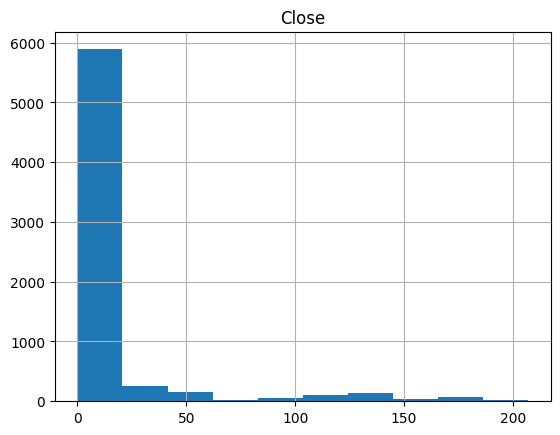

In [7]:
import matplotlib.pyplot as plt
nvidia_close.hist()

<Axes: xlabel='Date'>

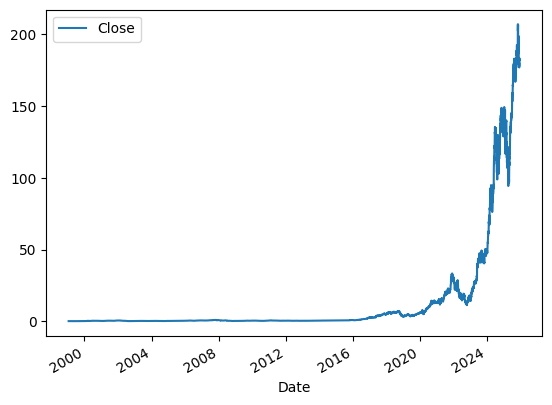

In [8]:
nvidia_close.plot()

In [9]:
nvidia_close_norm = (nvidia_close - nvidia_close.min()) / (nvidia_close.max() - nvidia_close.min())

<Axes: xlabel='Date'>

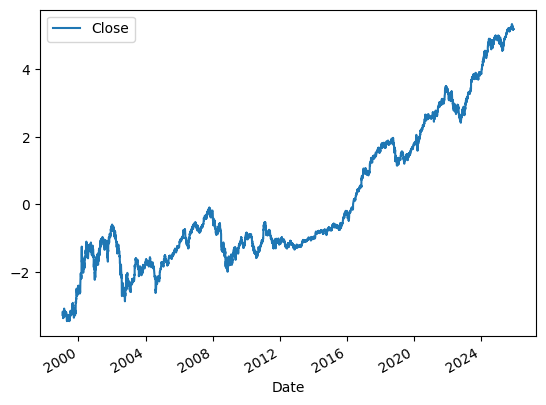

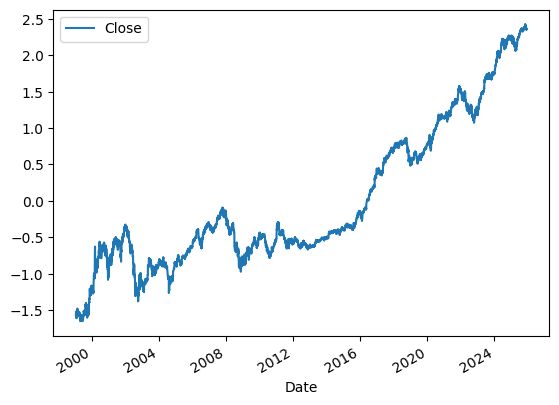

In [10]:
import numpy as np
nv_log = np.log(nvidia_close)
nv_log.plot()
nv = (nv_log - nv_log.mean()) / nv_log.std()
nv.plot()

# Data Splitting and Transforming

In [1]:
from data_handler import (
    extract_stock_close_price,
    log_transformation,
    standardization,
    inverse_transform,
    split_data,
    sliding_window,
    split_feature_targets,
)
from sequence_model import SimpleRNN, SimpleLSTM, train_model, test_model
import torch
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime


In [2]:
file = 'data/nvidia_stock_price_max_hist.csv'
close_raw = extract_stock_close_price("NVDA", "max", file, "Close")

test_ratio = 0.20
train_temp, test_raw = split_data(close_raw, test_ratio)

val_ratio = 0.20
train_raw, val_raw = split_data(train_temp, val_ratio)

train_log = log_transformation(train_raw)
train_clean, train_log_mean, train_log_std = standardization(train_log)

val_log = log_transformation(val_raw)
val_clean = (val_log - train_log_mean) / train_log_std

test_log = log_transformation(test_raw)
test_clean = (test_log - train_log_mean) / train_log_std

In [3]:
window_size = 20
window_step = 2
val_ratio = 0.20

train_set = sliding_window(train_clean, window_size, window_step)
X_train, y_train = split_feature_targets(train_set)

val_set = sliding_window(val_clean, window_size, window_step)
X_val, y_val = split_feature_targets(val_set)

test_set = sliding_window(test_clean, window_size, window_step)
X_test, y_test = split_feature_targets(test_set)

# RNN

In [4]:
rnn = SimpleRNN()
num_epochs=10
batch_size=32
learning_rate=0.002
rnn_train_loss, rnn_val_loss, (best_rnn_model, best_rnn_epoch) = train_model(
    rnn, num_epochs, batch_size, learning_rate, X_train, y_train, X_val, y_val
)

Epoch 1
Train loss: 1.114841561743079
Val Loss: 0.9833379372516099
Epoch 2
Train loss: 0.6951293272021062
Val Loss: 0.4545700563227429
Epoch 3
Train loss: 0.17905653515395792
Val Loss: 0.1301013674340485
Epoch 4
Train loss: 0.09850396873876247
Val Loss: 0.09085646885282853
Epoch 5
Train loss: 0.06861499323370962
Val Loss: 0.0699900509789586
Epoch 6
Train loss: 0.05095758159843493
Val Loss: 0.05426374218864914
Epoch 7
Train loss: 0.03821562671263939
Val Loss: 0.043989546603851896
Epoch 8
Train loss: 0.028087242666194525
Val Loss: 0.03581340786288766
Epoch 9
Train loss: 0.020461421823497136
Val Loss: 0.02916417462641702
Epoch 10
Train loss: 0.01563908365150222
Val Loss: 0.02355706013793893


In [11]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(best_rnn_model.state_dict(), f"saved_models/rnn_model_epoch_{best_rnn_epoch}_daytime_{timestamp}.pt")

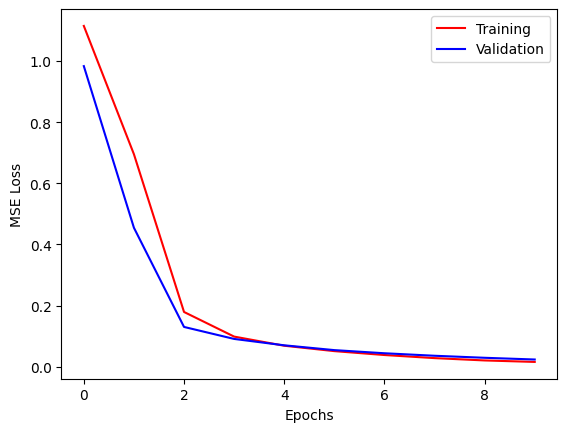

In [6]:
epochs = [*range(num_epochs)]
plt.plot(epochs, rnn_train_loss, label="Training", color="red")
plt.plot(epochs, rnn_val_loss, label="Validation", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [ ]:
# Load, test model, inverse transform it
from sequence_model import calculate_regression_metrics

rnn_file = "saved_models/rnn_model_epoch_10_daytime_20251220_053258.pt"
rnn_state_dict = torch.load(rnn_file)
best_rnn_model.load_state_dict(rnn_state_dict)

rnn_pred = test_model(best_rnn_model, X_test, y_test)

inverse_rnn_pred = inverse_transform(rnn_pred, train_log_mean, train_log_std)
y_true = inverse_transform(y_test, train_log_mean, train_log_std)

MSE, RMSE, MAE, R2 = calculate_regression_metrics(inverse_rnn_pred, y_true)

In [ ]:
print(f"MSE: {MSE}")
print(f"RSME: {RMSE}")
print(f"MAE: {MAE}")
print(f"R2: {R2}")

NameError: name 'MSE' is not defined

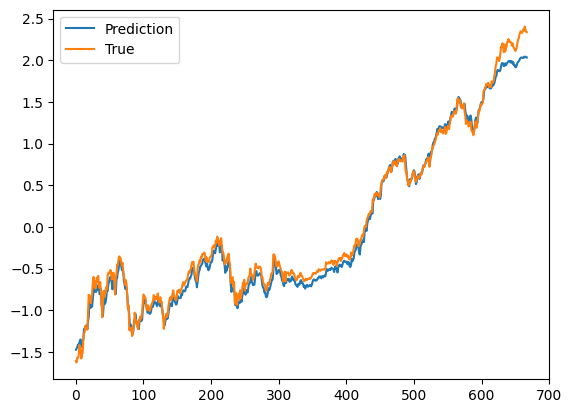

In [7]:
plt.plot(rnn_pred, label="Prediction")
plt.plot(y_test, label="True")
plt.legend()

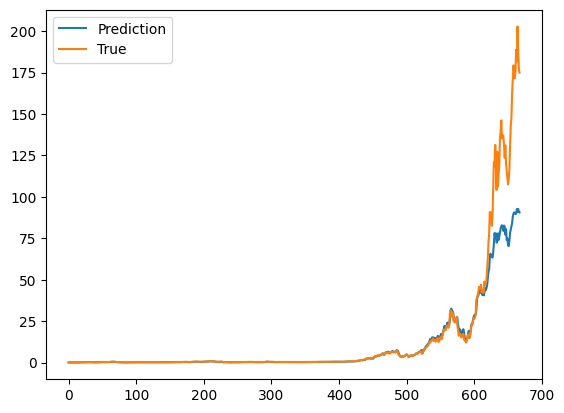

In [8]:
plt.plot(inverse_rnn_pred, label="Prediction")
plt.plot(y_true, label="True")
plt.legend()

# LSTM

In [7]:
lstm = SimpleLSTM()
num_epochs=10
batch_size=32
learning_rate=0.002
lstm_train_loss, lstm_val_loss, (best_lstm_model, best_lstm_epoch) = train_model(
    lstm, num_epochs, batch_size, learning_rate, X_train, y_train, X_val, y_val
)

Epoch 1
Train loss: 0.7359234403257313
Val Loss: 0.4565408249550006
Epoch 2
Train loss: 0.2191690646671786
Val Loss: 0.14663399915169814
Epoch 3
Train loss: 0.14997104721345855
Val Loss: 0.10296980664134026
Epoch 4
Train loss: 0.08293890472979161
Val Loss: 0.07384504177881514
Epoch 5
Train loss: 0.06257083481079248
Val Loss: 0.05139497408013353
Epoch 6
Train loss: 0.039113918956953805
Val Loss: 0.03977882699109614
Epoch 7
Train loss: 0.029136246215784922
Val Loss: 0.03241850035812925
Epoch 8
Train loss: 0.020764447734537124
Val Loss: 0.020708016955348497
Epoch 9
Train loss: 0.012383371155438534
Val Loss: 0.013498822757837307
Epoch 10
Train loss: 0.008066893601982669
Val Loss: 0.011564606745891711


In [10]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
torch.save(best_lstm_model.state_dict(), f"saved_models/lstm_model_epoch_{best_lstm_epoch}_daytime_{timestamp}.pt")

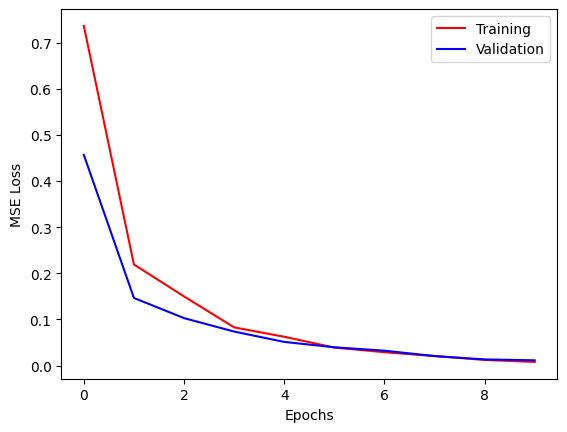

In [9]:
epochs = [*range(num_epochs)]
plt.plot(epochs, lstm_train_loss, label="Training", color="red")
plt.plot(epochs, lstm_val_loss, label="Validation", color="blue")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [ ]:
# Load and test model
from sequence_model import calculate_regression_metrics

lstm_file = "saved_models/lstm_model_epoch_10_daytime_20251220_053258.pt"
lstm_state_dict = torch.load(lstm_file)
best_lstm_model.load_state_dict(lstm_state_dict)

lstm_pred = test_model(best_lstm_model, X_test, y_test)

inverse_lstm_pred = inverse_transform(lstm_pred, train_log_mean, train_log_std)
y_true = inverse_transform(y_test, train_log_mean, train_log_std)

MSE, RMSE, MAE, R2 = calculate_regression_metrics(inverse_lstm_pred, y_true)

In [ ]:
print(f"MSE: {MSE}")
print(f"RSME: {RMSE}")
print(f"MAE: {MAE}")
print(f"R2: {R2}")

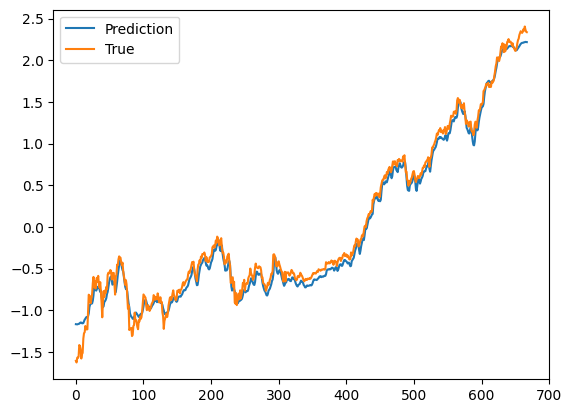

In [15]:
plt.plot(lstm_pred, label="Prediction")
plt.plot(y_test, label="True")
plt.legend()

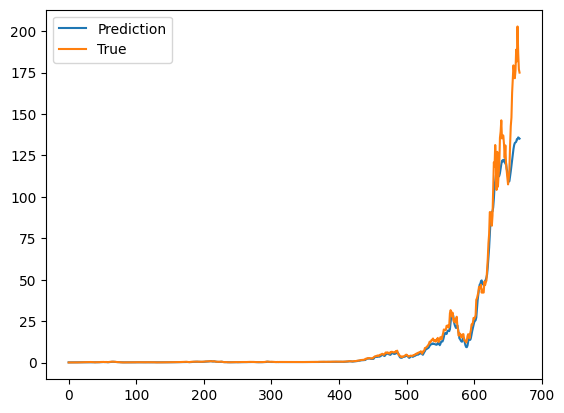

In [16]:
plt.plot(inverse_lstm_pred, label="Prediction")
plt.plot(y_true, label="True")
plt.legend()